### Importing Libraries

In [1]:
#Importing imp libraries
import cv2
import csv
import time
import numpy as np
import os 
import pandas as pd
import mediapipe as mp
import matplotlib.pyplot as plt
#Importing libraries to create a neural network 
import tensorflow as tf
from sklearn.model_selection import train_test_split 

2023-11-02 14:48:56.182027: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-02 14:48:56.846469: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-02 14:48:56.846530: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-02 14:48:56.846762: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-02 14:48:57.072563: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-02 14:48:59.222518: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

### Using mediapipe for hand landmark detection

In [2]:
#Initializing mediapipe hand landmark detection class
mp_hands = mp.solutions.hands

#Hand function
hands = mp_hands.Hands(static_image_mode=True,max_num_hands=1,min_detection_confidence=0.3)

#Mediapipe drawing class
mp_drawing = mp.solutions.drawing_utils

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


### Visualizing a sample image

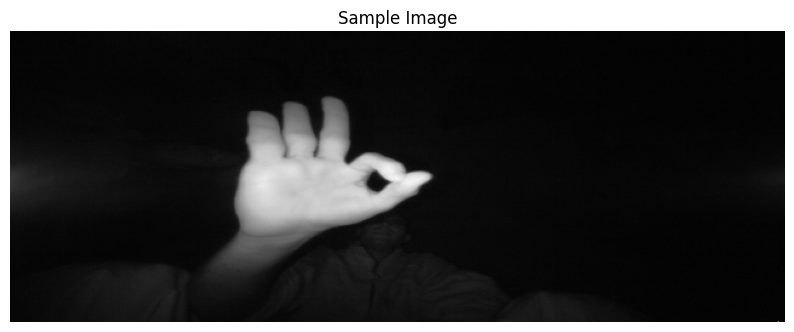

In [4]:
#Sample training image
sample_img = cv2.imread('Test_pics/ok_shape.png')

plt.figure(figsize=[10,10])
plt.title('Sample Image')
plt.axis('off')

#Converting BGR to RGB and  plotting the image
plt.imshow(sample_img[:,:,::-1])
plt.show()

### Detecting hand landmarks with visualization

In [5]:
#Hand Landmarks detection
results = hands.process(cv2.cvtColor(sample_img,cv2.COLOR_BGR2RGB))

#checking if landamrks are found
if results.multi_hand_landmarks:

    #Iterating over the found hands.
    for hand_no , hand_landmarks in enumerate(results.multi_hand_landmarks):
        print(f'Hand Number{hand_no}')
        print('---------------------')

        #Iterating five times to show first five landmarks:
        for i in range(5):

            #Displaying the normalized coordinates of the landmarks
            print(f'{mp_hands.HandLandmark(i).name}:')
            print(f'{hand_landmarks.landmark[mp_hands.HandLandmark(i).value]}')
        
    

Hand Number0
---------------------
WRIST:
x: 0.35266554
y: 0.6708237
z: 2.4313775e-07

THUMB_CMC:
x: 0.40301287
y: 0.6571926
z: -0.01797175

THUMB_MCP:
x: 0.45567515
y: 0.60031724
z: -0.025647903

THUMB_IP:
x: 0.4957285
y: 0.55076605
z: -0.033627357

THUMB_TIP:
x: 0.5279181
y: 0.50734276
z: -0.042893738



### Note: We get the normalized coordinates for 21 of thsese landmarks

### Changing to absolute value

In [6]:
#Getting height and width of the sample image
image_height,image_width,_ = sample_img.shape


#checking if landamrks are found
if results.multi_hand_landmarks:

    #Iterating over the found hands.
    for hand_no , hand_landmarks in enumerate(results.multi_hand_landmarks):
        print(f'Hand Number{hand_no}')
        print('---------------------')

        #Iterating five times to show first five landmarks:
        for i in range(5):

            #Displaying the actual coordinates of the landmarks
            print(f'{mp_hands.HandLandmark(i).name}:')
            print(f'{hand_landmarks.landmark[mp_hands.HandLandmark(i).value].x * image_width}')
            print(f'{hand_landmarks.landmark[mp_hands.HandLandmark(i).value].y * image_height}')
            print(f'{hand_landmarks.landmark[mp_hands.HandLandmark(i).value].z * image_width}')

Hand Number0
---------------------
WRIST:
225.70594787597656
160.9976863861084
0.00015560815882054158
THUMB_CMC:
257.92823791503906
157.72622108459473
-11.501920223236084
THUMB_MCP:
291.6320991516113
144.0761375427246
-16.414657831192017
THUMB_IP:
317.2662353515625
132.18385219573975
-21.52150869369507
THUMB_TIP:
337.8675842285156
121.76226139068604
-27.45199203491211


### Visualizing landmarks points

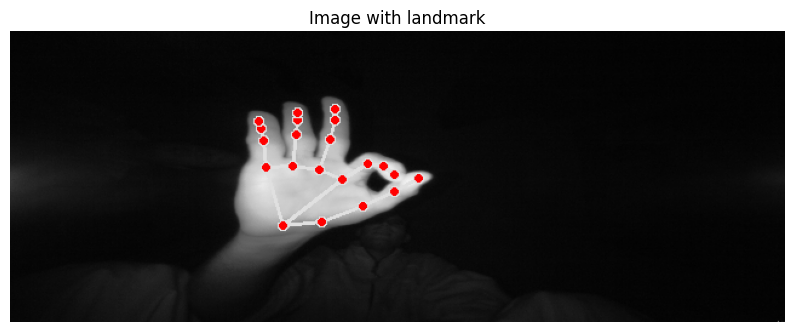

In [7]:
#Copying image
img_copy = sample_img.copy()

#Check if landmarks are found
if results.multi_hand_landmarks:

    for hand_no,hand_landmarks in enumerate(results.multi_hand_landmarks):

        #Draw the hand landmark on copied img
        mp_drawing.draw_landmarks(image=img_copy,landmark_list = hand_landmarks,connections=mp_hands.HAND_CONNECTIONS)

        fig = plt.figure(figsize=[10,10])

        #Displaying the image with landmarks
        plt.title('Image with landmark')
        plt.axis('off')
        plt.imshow(img_copy[:,:,::-1])
        plt.show()

### Function to convert all training images into the data-points

In [8]:
#Creating the dataset of landmarks from the images
def addToData(imagePath,label):
    current_img = cv2.imread(imagePath)
    
    results = hands.process(cv2.cvtColor(current_img,cv2.COLOR_BGR2RGB))
    landmark_point = []
    if results.multi_hand_landmarks:
        landmark_point.append(label)
        for _ , hand_landmarks in enumerate(results.multi_hand_landmarks):
            for i in range(21):
                landmark_point.append(hand_landmarks.landmark[mp_hands.HandLandmark(i).value].x)
                landmark_point.append(hand_landmarks.landmark[mp_hands.HandLandmark(i).value].y)
                landmark_point.append(hand_landmarks.landmark[mp_hands.HandLandmark(i).value].z)
        return landmark_point

### Loading the training data

In [9]:
total_data = []
Categories = ['Palm','L-shape','Fist','Fist-moved','Thumb','Index','OK','Palm-moved','C-shape','Down']
path = ['Train_Pics/00','Train_Pics/01','Train_Pics/02','Train_Pics/03','Train_Pics/04','Train_Pics/05','Train_Pics/06','Train_Pics/07','Train_Pics/08','Train_Pics/09']
for i in range(len(path)):
    print(f'Adding data of file {path[i]}')
    for index,categories in enumerate(os.listdir(path[i])):
        print(f'Adding data points of category: {Categories[index]}')
        for img in os.listdir(os.path.join(path[i],categories)):
             data = addToData(os.path.join(path[i],categories,img),index)
             if data != None:
                total_data.append(data)
dataframe = pd.DataFrame(total_data)
dataframe.to_csv('Data_points.csv',index=False)

Adding data of file Train_Pics/00
Adding data points of category: Palm
Adding data points of category: L-shape
Adding data points of category: Fist
Adding data points of category: Fist-moved
Adding data points of category: Thumb
Adding data points of category: Index
Adding data points of category: OK
Adding data points of category: Palm-moved
Adding data points of category: C-shape
Adding data points of category: Down
Adding data of file Train_Pics/01
Adding data points of category: Palm
Adding data points of category: L-shape
Adding data points of category: Fist
Adding data points of category: Fist-moved
Adding data points of category: Thumb
Adding data points of category: Index
Adding data points of category: OK
Adding data points of category: Palm-moved
Adding data points of category: C-shape
Adding data points of category: Down
Adding data of file Train_Pics/02
Adding data points of category: Palm
Adding data points of category: L-shape
Adding data points of category: Fist
Adding d

### Datapoints saved in 'Data_points.csv' file

In [10]:
#visualizing dataframe
df = pd.read_csv('Data_points.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0,0.549743,0.915456,7.687930e-08,0.595048,0.837279,-0.008609,0.616668,0.728658,-0.013568,...,-0.006526,0.482241,0.554720,-0.005249,0.488624,0.525713,0.001286,0.492299,0.524950,0.007504
1,0,0.549743,0.915456,7.687930e-08,0.595048,0.837279,-0.008609,0.616668,0.728658,-0.013568,...,-0.006526,0.482241,0.554720,-0.005249,0.488624,0.525713,0.001286,0.492299,0.524950,0.007504
2,0,0.633694,0.858362,3.625893e-08,0.638863,0.775937,0.006126,0.628638,0.661731,0.010152,...,0.003244,0.572730,0.556923,0.009545,0.574284,0.515890,0.017105,0.574611,0.493020,0.023114
3,0,0.633694,0.858362,3.625893e-08,0.638863,0.775937,0.006126,0.628638,0.661731,0.010152,...,0.003244,0.572730,0.556923,0.009545,0.574284,0.515890,0.017105,0.574611,0.493020,0.023114
4,0,0.533771,0.943115,1.307391e-07,0.581950,0.855429,-0.007617,0.603052,0.738049,-0.009864,...,0.004355,0.460203,0.558124,0.007289,0.467690,0.519983,0.012526,0.471952,0.505153,0.016916


### Train data

In [11]:
#Total Categories/ Classes:
X = np.array(df[df.columns[1:]])
y = np.array(df[df.columns[0]])
print(X.shape,y.shape)

(8491, 63) (8491,)


## Train-Test split

In [12]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Creating NN to classify those datapoints from mediapipe based on the training data into 10 separate classes

In [13]:
#Creating the neural network model for classification
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 3, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [14]:
#model details
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 63)                0         
                                                                 
 dense (Dense)               (None, 32)                2048      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 10)                170       
                                                                 
Total params: 2746 (10.73 KB)
Trainable params: 2746 (10.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Model Compilation

In [15]:
#Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Training the model

In [16]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=64,
    validation_data=(X_test, y_test)
)

Epoch 1/1000
100/100 [==============================] - 2s 5ms/step - loss: 2.1808 - accuracy: 0.1971 - val_loss: 2.0238 - val_accuracy: 0.2944
Epoch 2/1000
100/100 [==============================] - 0s 2ms/step - loss: 2.0085 - accuracy: 0.2853 - val_loss: 1.8871 - val_accuracy: 0.3542
Epoch 3/1000
100/100 [==============================] - 0s 2ms/step - loss: 1.8922 - accuracy: 0.3364 - val_loss: 1.7521 - val_accuracy: 0.4253
Epoch 4/1000
100/100 [==============================] - 0s 2ms/step - loss: 1.7932 - accuracy: 0.3714 - val_loss: 1.6045 - val_accuracy: 0.4607
Epoch 5/1000
100/100 [==============================] - 0s 2ms/step - loss: 1.7049 - accuracy: 0.3984 - val_loss: 1.4990 - val_accuracy: 0.4828
Epoch 6/1000
100/100 [==============================] - 0s 2ms/step - loss: 1.6504 - accuracy: 0.4147 - val_loss: 1.4337 - val_accuracy: 0.5365
Epoch 7/1000
100/100 [==============================] - 0s 2ms/step - loss: 1.5900 - accuracy: 0.4273 - val_loss: 1.3362 - val_accuracy:

100/100 [==============================] - 0s 2ms/step - loss: 1.1906 - accuracy: 0.5601 - val_loss: 1.0976 - val_accuracy: 0.6387
Epoch 58/1000
100/100 [==============================] - 0s 2ms/step - loss: 1.1610 - accuracy: 0.5702 - val_loss: 1.0616 - val_accuracy: 0.6571
Epoch 59/1000
100/100 [==============================] - 0s 2ms/step - loss: 1.1598 - accuracy: 0.5707 - val_loss: 1.0974 - val_accuracy: 0.6321
Epoch 60/1000
100/100 [==============================] - 0s 2ms/step - loss: 1.1641 - accuracy: 0.5694 - val_loss: 1.0602 - val_accuracy: 0.6642
Epoch 61/1000
100/100 [==============================] - 0s 2ms/step - loss: 1.1693 - accuracy: 0.5682 - val_loss: 1.1029 - val_accuracy: 0.6260
Epoch 62/1000
100/100 [==============================] - 0s 2ms/step - loss: 1.1504 - accuracy: 0.5721 - val_loss: 1.0370 - val_accuracy: 0.6905
Epoch 63/1000
100/100 [==============================] - 0s 2ms/step - loss: 1.1536 - accuracy: 0.5726 - val_loss: 1.0900 - val_accuracy: 0.6566

100/100 [==============================] - 0s 2ms/step - loss: 0.9268 - accuracy: 0.6633 - val_loss: 1.0880 - val_accuracy: 0.5794
Epoch 114/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.9435 - accuracy: 0.6577 - val_loss: 1.1097 - val_accuracy: 0.5337
Epoch 115/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.9209 - accuracy: 0.6564 - val_loss: 1.0857 - val_accuracy: 0.5294
Epoch 116/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.9317 - accuracy: 0.6584 - val_loss: 1.0471 - val_accuracy: 0.5464
Epoch 117/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.9150 - accuracy: 0.6682 - val_loss: 1.1570 - val_accuracy: 0.5332
Epoch 118/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.9420 - accuracy: 0.6559 - val_loss: 1.1112 - val_accuracy: 0.5021
Epoch 119/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.9199 - accuracy: 0.6619 - val_loss: 1.1191 - val_accuracy: 

100/100 [==============================] - 0s 2ms/step - loss: 0.8511 - accuracy: 0.6855 - val_loss: 1.1829 - val_accuracy: 0.4885
Epoch 170/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.8342 - accuracy: 0.6917 - val_loss: 1.1715 - val_accuracy: 0.4654
Epoch 171/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.8218 - accuracy: 0.7060 - val_loss: 1.1553 - val_accuracy: 0.5068
Epoch 172/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.8284 - accuracy: 0.6986 - val_loss: 1.1425 - val_accuracy: 0.5572
Epoch 173/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.8303 - accuracy: 0.6988 - val_loss: 1.1675 - val_accuracy: 0.5040
Epoch 174/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.8362 - accuracy: 0.6997 - val_loss: 1.1551 - val_accuracy: 0.5144
Epoch 175/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.8217 - accuracy: 0.7057 - val_loss: 1.1068 - val_accuracy: 

100/100 [==============================] - 0s 2ms/step - loss: 0.7861 - accuracy: 0.7153 - val_loss: 1.1846 - val_accuracy: 0.4932
Epoch 226/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.7816 - accuracy: 0.7192 - val_loss: 1.2816 - val_accuracy: 0.4569
Epoch 227/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.7864 - accuracy: 0.7192 - val_loss: 1.2936 - val_accuracy: 0.4541
Epoch 228/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.7764 - accuracy: 0.7194 - val_loss: 1.2889 - val_accuracy: 0.4512
Epoch 229/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.7688 - accuracy: 0.7258 - val_loss: 1.2510 - val_accuracy: 0.4611
Epoch 230/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.7687 - accuracy: 0.7208 - val_loss: 1.2851 - val_accuracy: 0.4626
Epoch 231/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.7760 - accuracy: 0.7220 - val_loss: 1.2659 - val_accuracy: 

100/100 [==============================] - 0s 2ms/step - loss: 0.7332 - accuracy: 0.7370 - val_loss: 1.3010 - val_accuracy: 0.4503
Epoch 282/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.7394 - accuracy: 0.7392 - val_loss: 1.3391 - val_accuracy: 0.4371
Epoch 283/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.7497 - accuracy: 0.7301 - val_loss: 1.3458 - val_accuracy: 0.4503
Epoch 284/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.7372 - accuracy: 0.7341 - val_loss: 1.2829 - val_accuracy: 0.4626
Epoch 285/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.7262 - accuracy: 0.7351 - val_loss: 1.2892 - val_accuracy: 0.4753
Epoch 286/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.7407 - accuracy: 0.7363 - val_loss: 1.3293 - val_accuracy: 0.4451
Epoch 287/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.7209 - accuracy: 0.7406 - val_loss: 1.2733 - val_accuracy: 

100/100 [==============================] - 0s 2ms/step - loss: 0.7145 - accuracy: 0.7465 - val_loss: 1.3388 - val_accuracy: 0.4522
Epoch 338/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.6980 - accuracy: 0.7503 - val_loss: 1.3527 - val_accuracy: 0.4461
Epoch 339/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.7505 - val_loss: 1.3352 - val_accuracy: 0.4489
Epoch 340/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.7043 - accuracy: 0.7539 - val_loss: 1.3706 - val_accuracy: 0.4366
Epoch 341/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.6905 - accuracy: 0.7575 - val_loss: 1.2341 - val_accuracy: 0.4988
Epoch 342/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.6861 - accuracy: 0.7577 - val_loss: 1.3507 - val_accuracy: 0.4432
Epoch 343/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.7511 - val_loss: 1.3863 - val_accuracy: 

100/100 [==============================] - 0s 2ms/step - loss: 0.6675 - accuracy: 0.7643 - val_loss: 1.3460 - val_accuracy: 0.4470
Epoch 394/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.6711 - accuracy: 0.7588 - val_loss: 1.3691 - val_accuracy: 0.4371
Epoch 395/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.6638 - accuracy: 0.7585 - val_loss: 1.3556 - val_accuracy: 0.4663
Epoch 396/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.6629 - accuracy: 0.7655 - val_loss: 1.4296 - val_accuracy: 0.4366
Epoch 397/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.6713 - accuracy: 0.7663 - val_loss: 1.3785 - val_accuracy: 0.4451
Epoch 398/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.6568 - accuracy: 0.7706 - val_loss: 1.4275 - val_accuracy: 0.4301
Epoch 399/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.6614 - accuracy: 0.7619 - val_loss: 1.3763 - val_accuracy: 

100/100 [==============================] - 0s 2ms/step - loss: 0.6543 - accuracy: 0.7646 - val_loss: 1.4298 - val_accuracy: 0.4126
Epoch 450/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.6326 - accuracy: 0.7734 - val_loss: 1.3191 - val_accuracy: 0.4682
Epoch 451/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.6409 - accuracy: 0.7739 - val_loss: 1.4039 - val_accuracy: 0.4418
Epoch 452/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.6389 - accuracy: 0.7772 - val_loss: 1.4638 - val_accuracy: 0.4244
Epoch 453/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.6500 - accuracy: 0.7723 - val_loss: 1.3360 - val_accuracy: 0.4456
Epoch 454/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.6348 - accuracy: 0.7718 - val_loss: 1.4558 - val_accuracy: 0.4197
Epoch 455/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.6373 - accuracy: 0.7750 - val_loss: 1.3763 - val_accuracy: 

100/100 [==============================] - 0s 2ms/step - loss: 0.6160 - accuracy: 0.7825 - val_loss: 1.4663 - val_accuracy: 0.4183
Epoch 506/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.6340 - accuracy: 0.7797 - val_loss: 1.4513 - val_accuracy: 0.4126
Epoch 507/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.6171 - accuracy: 0.7791 - val_loss: 1.4307 - val_accuracy: 0.4465
Epoch 508/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.6325 - accuracy: 0.7803 - val_loss: 1.5055 - val_accuracy: 0.4154
Epoch 509/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.6181 - accuracy: 0.7769 - val_loss: 1.4402 - val_accuracy: 0.4296
Epoch 510/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.6227 - accuracy: 0.7830 - val_loss: 1.4016 - val_accuracy: 0.4409
Epoch 511/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.6207 - accuracy: 0.7834 - val_loss: 1.4425 - val_accuracy: 

100/100 [==============================] - 0s 2ms/step - loss: 0.6124 - accuracy: 0.7889 - val_loss: 1.4983 - val_accuracy: 0.4008
Epoch 562/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.6109 - accuracy: 0.7860 - val_loss: 1.4655 - val_accuracy: 0.3933
Epoch 563/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.6112 - accuracy: 0.7889 - val_loss: 1.4734 - val_accuracy: 0.4131
Epoch 564/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.6305 - accuracy: 0.7773 - val_loss: 1.4140 - val_accuracy: 0.4206
Epoch 565/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.6064 - accuracy: 0.7897 - val_loss: 1.5343 - val_accuracy: 0.3952
Epoch 566/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.6168 - accuracy: 0.7839 - val_loss: 1.4864 - val_accuracy: 0.4070
Epoch 567/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.6093 - accuracy: 0.7877 - val_loss: 1.5100 - val_accuracy: 

100/100 [==============================] - 0s 2ms/step - loss: 0.6127 - accuracy: 0.7852 - val_loss: 1.4172 - val_accuracy: 0.4140
Epoch 618/1000
100/100 [==============================] - 0s 3ms/step - loss: 0.5941 - accuracy: 0.7915 - val_loss: 1.4333 - val_accuracy: 0.4178
Epoch 619/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.5972 - accuracy: 0.7927 - val_loss: 1.5523 - val_accuracy: 0.3933
Epoch 620/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.5934 - accuracy: 0.7940 - val_loss: 1.4748 - val_accuracy: 0.4117
Epoch 621/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.5940 - accuracy: 0.7883 - val_loss: 1.5008 - val_accuracy: 0.3961
Epoch 622/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.6024 - accuracy: 0.7899 - val_loss: 1.4998 - val_accuracy: 0.4004
Epoch 623/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.5946 - accuracy: 0.7926 - val_loss: 1.4455 - val_accuracy: 

100/100 [==============================] - 0s 2ms/step - loss: 0.5926 - accuracy: 0.7935 - val_loss: 1.5048 - val_accuracy: 0.4023
Epoch 674/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.5876 - accuracy: 0.7959 - val_loss: 1.4822 - val_accuracy: 0.4164
Epoch 675/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.6004 - accuracy: 0.7921 - val_loss: 1.4544 - val_accuracy: 0.4164
Epoch 676/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.6030 - accuracy: 0.7864 - val_loss: 1.4830 - val_accuracy: 0.4023
Epoch 677/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.5802 - accuracy: 0.7916 - val_loss: 1.5286 - val_accuracy: 0.4056
Epoch 678/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.5965 - accuracy: 0.7871 - val_loss: 1.4358 - val_accuracy: 0.4126
Epoch 679/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.5887 - accuracy: 0.7944 - val_loss: 1.4551 - val_accuracy: 

100/100 [==============================] - 0s 2ms/step - loss: 0.5786 - accuracy: 0.7952 - val_loss: 1.5052 - val_accuracy: 0.4070
Epoch 730/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.5763 - accuracy: 0.7987 - val_loss: 1.4839 - val_accuracy: 0.4023
Epoch 731/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.5921 - accuracy: 0.7922 - val_loss: 1.5690 - val_accuracy: 0.3848
Epoch 732/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.5898 - accuracy: 0.7949 - val_loss: 1.6185 - val_accuracy: 0.3943
Epoch 733/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.5750 - accuracy: 0.7938 - val_loss: 1.4320 - val_accuracy: 0.4258
Epoch 734/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.5949 - accuracy: 0.7938 - val_loss: 1.5292 - val_accuracy: 0.3806
Epoch 735/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.5850 - accuracy: 0.7940 - val_loss: 1.4122 - val_accuracy: 

100/100 [==============================] - 0s 2ms/step - loss: 0.5897 - accuracy: 0.7973 - val_loss: 1.5343 - val_accuracy: 0.3928
Epoch 786/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.5857 - accuracy: 0.7981 - val_loss: 1.5066 - val_accuracy: 0.4098
Epoch 787/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.6047 - accuracy: 0.7889 - val_loss: 1.6241 - val_accuracy: 0.3900
Epoch 788/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.5872 - accuracy: 0.7960 - val_loss: 1.5250 - val_accuracy: 0.4098
Epoch 789/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.6098 - accuracy: 0.7844 - val_loss: 1.4589 - val_accuracy: 0.4027
Epoch 790/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.6046 - accuracy: 0.7885 - val_loss: 1.5028 - val_accuracy: 0.4140
Epoch 791/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.5796 - accuracy: 0.7990 - val_loss: 1.5256 - val_accuracy: 

100/100 [==============================] - 0s 2ms/step - loss: 0.5808 - accuracy: 0.7899 - val_loss: 1.4397 - val_accuracy: 0.4183
Epoch 842/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.5772 - accuracy: 0.8024 - val_loss: 1.4945 - val_accuracy: 0.4051
Epoch 843/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.5893 - accuracy: 0.7957 - val_loss: 1.4094 - val_accuracy: 0.4597
Epoch 844/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.5895 - accuracy: 0.7951 - val_loss: 1.4375 - val_accuracy: 0.4216
Epoch 845/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.5798 - accuracy: 0.7982 - val_loss: 1.5279 - val_accuracy: 0.4065
Epoch 846/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.5845 - accuracy: 0.7926 - val_loss: 1.4840 - val_accuracy: 0.4032
Epoch 847/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.5585 - accuracy: 0.8040 - val_loss: 1.5878 - val_accuracy: 

100/100 [==============================] - 0s 2ms/step - loss: 0.5782 - accuracy: 0.7995 - val_loss: 1.5949 - val_accuracy: 0.3895
Epoch 898/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.5702 - accuracy: 0.8024 - val_loss: 1.4548 - val_accuracy: 0.4183
Epoch 899/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.5778 - accuracy: 0.8012 - val_loss: 1.4302 - val_accuracy: 0.4291
Epoch 900/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.5884 - accuracy: 0.7926 - val_loss: 1.5383 - val_accuracy: 0.4032
Epoch 901/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.6045 - accuracy: 0.7850 - val_loss: 1.5029 - val_accuracy: 0.3985
Epoch 902/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.5820 - accuracy: 0.7995 - val_loss: 1.6041 - val_accuracy: 0.3900
Epoch 903/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.5661 - accuracy: 0.8072 - val_loss: 1.4535 - val_accuracy: 

100/100 [==============================] - 0s 2ms/step - loss: 0.5670 - accuracy: 0.8075 - val_loss: 1.5086 - val_accuracy: 0.4249
Epoch 954/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.5802 - accuracy: 0.7981 - val_loss: 1.4558 - val_accuracy: 0.4074
Epoch 955/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.5863 - accuracy: 0.7916 - val_loss: 1.4964 - val_accuracy: 0.4249
Epoch 956/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.5692 - accuracy: 0.8062 - val_loss: 1.5186 - val_accuracy: 0.4018
Epoch 957/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.5910 - accuracy: 0.7937 - val_loss: 1.4804 - val_accuracy: 0.4041
Epoch 958/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.5725 - accuracy: 0.8051 - val_loss: 1.4991 - val_accuracy: 0.4018
Epoch 959/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.5891 - accuracy: 0.7965 - val_loss: 1.4853 - val_accuracy: 

### Checking the accuracy of the model

In [17]:
#Accuracy of the model
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=64)

34/34 [==============================] - 0s 1ms/step - loss: 1.5591 - accuracy: 0.3938


### Predicting the first index of test data

In [18]:
#Predicting the result
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 96ms/step
[1.2367344e-02 1.0185011e-02 2.6853539e-02 1.2922314e-05 1.3655065e-01
 2.0870149e-02 3.7849884e-02 1.8430019e-07 1.0306227e-04 7.5520724e-01]
9


### Model predicted the correct category

In [19]:
print(y_test[0])

9


### Function which predict the hand gesture with the provided image and using the above model

In [20]:
#Function to predict the gesture given the picture
def predictHandGesture(imagePath):
    #Collecting landmark datapoints
    imageDataPoints = []
    imgToPredict = cv2.imread(imagePath)
    handPointsResults = hands.process(cv2.cvtColor(imgToPredict,cv2.COLOR_BGR2RGB))
    if handPointsResults.multi_hand_landmarks:
        for _ , hand_landmarks in enumerate(handPointsResults.multi_hand_landmarks):
            #Drawing Landmarks
            mp_drawing.draw_landmarks(image=imgToPredict,landmark_list = hand_landmarks,connections=mp_hands.HAND_CONNECTIONS)
            
            fig = plt.figure(figsize=[10,10])
            plt.title('Image with landmark')
            plt.axis('off')
            plt.imshow(imgToPredict[:,:,::-1])
            plt.show()
            for i in range(21):
                imageDataPoints.append(hand_landmarks.landmark[mp_hands.HandLandmark(i).value].x)
                imageDataPoints.append(hand_landmarks.landmark[mp_hands.HandLandmark(i).value].y)
                imageDataPoints.append(hand_landmarks.landmark[mp_hands.HandLandmark(i).value].z)
    prediction_array = np.array([imageDataPoints])
    
    #Predicting Result
    gesture_prediction = model.predict(prediction_array)
    print(f' Confidence for each category: {np.squeeze(predict_result)}')
    predicted_category = np.argmax(np.squeeze(gesture_prediction))
    print(f'Maximum confidence category is: {predicted_category}')
    
    #Predicted Category
    print(f'The hand gesture is of category: {Categories[predicted_category]}')
    

### Predicting few of the test images

OK Shape is predicted below:


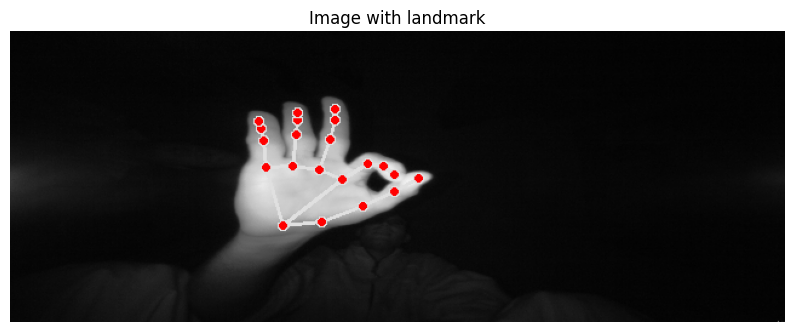

1/1 [==============================] - 0s 19ms/step
 Confidence for each category: [1.2367344e-02 1.0185011e-02 2.6853539e-02 1.2922314e-05 1.3655065e-01
 2.0870149e-02 3.7849884e-02 1.8430019e-07 1.0306227e-04 7.5520724e-01]
Maximum confidence category is: 6
The hand gesture is of category: OK
L shape is predicted below:


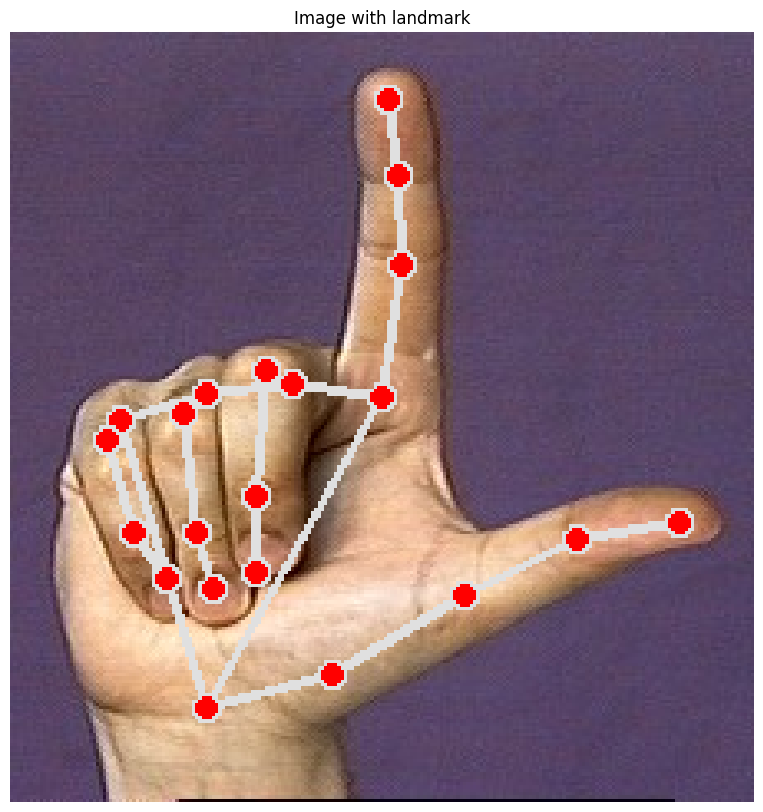

1/1 [==============================] - 0s 19ms/step
 Confidence for each category: [1.2367344e-02 1.0185011e-02 2.6853539e-02 1.2922314e-05 1.3655065e-01
 2.0870149e-02 3.7849884e-02 1.8430019e-07 1.0306227e-04 7.5520724e-01]
Maximum confidence category is: 1
The hand gesture is of category: L-shape


In [23]:
#Predicting few images:
image_ok = 'Test_pics/ok_shape.png'
image_l = 'Test_pics/l_shape.jpg'

#Predicting the OK Shape
print('OK Shape is predicted below:')
predictHandGesture(image_ok)

#Predicting the L shape
print('L shape is predicted below:')
predictHandGesture(image_l)

## In conclusion, we used mediapipe to get hand landmarks and then used a simple feed forward neural network to train the landmark data with the training images. 